# MA3J8 Approximation Theory and Applications

## 07 - Examples of Nonlinear Approximation



In [1]:
using Plots, Remez, LaTeXStrings, LinearAlgebra; gr()

chebnodes(N) = [ cos(j*π/N) for j = N:-1:0 ]
function bary(f::Function, N, x)
    X = chebnodes(N)
    F = f.(X)
    return bary(F, x; X=X)
end
function bary(F::Vector, x; X = chebnodes(length(F)-1))
    N = length(F)-1
    p = 0.5 * ( F[1] ./ (x .- X[1]) + (-1)^N * F[N+1] ./(x .- X[N+1]) )
    q = 0.5 * (1.0 ./ (x .- X[1]) + (-1)^N ./ (x .- X[N+1]))
    for n = 1:N-1
        p += (-1)^n * F[n+1] ./ (x .- X[n+1])
        q += (-1)^n ./ (x .- X[n+1])
    end 
    return p ./ q    
end
errgrid(Np) = range(-1+0.0123, stop=1-0.00321, length=Np)

┌ Info: Recompiling stale cache file /Users/ortner/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/ortner/.julia/compiled/v1.1/Remez/mJYI7.ji for Remez [2e7db186-766a-50e7-8928-5c30181fb135]
└ @ Base loading.jl:1184


errgrid (generic function with 1 method)

### 07-1 Example 1: Pole removal

In [2]:
# recall the standard polynomial approximation for the
# Fermi-dirac function 
β = 100
f(x) = 1/(1+exp(β*x))

f (generic function with 1 method)

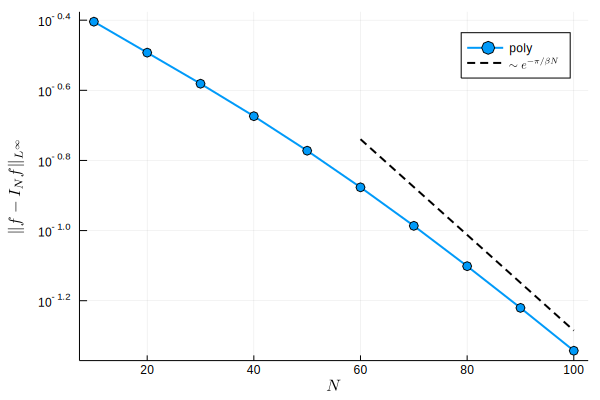

In [8]:
NN = 10:10:100
xerr = errgrid(1_000)
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"))
err = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N in NN ]
t = [NN[6], NN[10]]
plot!(NN, err, lw=2, m=:o, label = "poly")
plot!(t, 1.2*exp.(-π/β*t), lw=2, ls=:dash, c=:black, label=L"\sim e^{-\pi/\beta N}")

In [9]:
# construct the first few fn and look at those rates
# --------------------------------------------------
α(n) = (2*n-1)*π/β
g(x, n) = -2/β*x/(x^2+α(n)^2)
f(x, n) = (n == 0 ? f(x) : f(x,n-1) - g(x,n))

f (generic function with 2 methods)

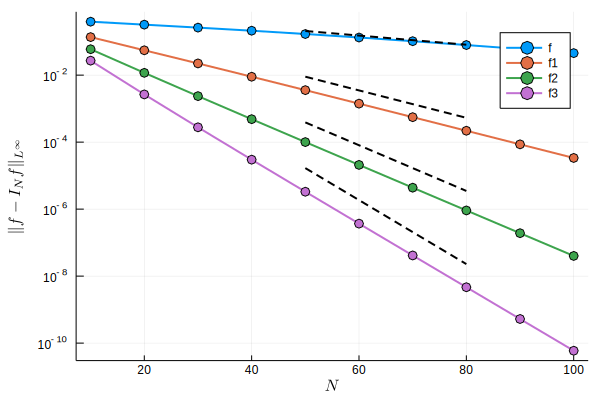

In [10]:
NN = 10:10:100
xerr = errgrid(1_000)
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_N f\|_{L^\infty}"))
err0 = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N in NN ]
err1 = [ norm(f.(xerr, 1) - bary(x->f(x,1), N, xerr), Inf)  for N in NN ]
err2 = [ norm(f.(xerr, 2) - bary(x->f(x,2), N, xerr), Inf)  for N in NN ]
err3 = [ norm(f.(xerr, 3) - bary(x->f(x,3), N, xerr), Inf)  for N in NN ]
t = [NN[5], NN[8]]
plot!(NN, err, lw=2, m=:o, label = "f")
plot!(NN, err1, lw=2, m=:o, label = "f1")
plot!(NN, err2, lw=2, m=:o, label = "f2")
plot!(NN, err3, lw=2, m=:o, label = "f3")
plot!(t, [exp.(-α(n)*t) for n = 1:4], lw=2, ls=:dash, c=:black, label="")

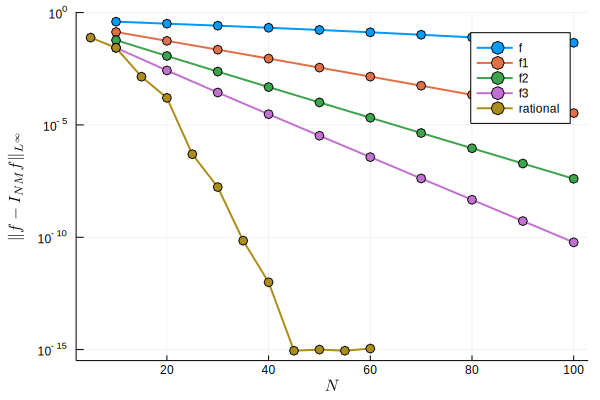

In [12]:
# Now let's try to make this super-exponential
Nr = 5:5:60
xerr = errgrid(1_000)
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_{NM} f\|_{L^\infty}"))
errsuper = [] 
for N = Nr 
    n = ceil(Int,N/4)
    push!(errsuper, norm(f.(xerr, n) - bary(x->f(x,n), N, xerr), Inf))
end 
plot!(NN, err, lw=2, m=:o, label = "f")
plot!(NN, err1, lw=2, m=:o, label = "f1")
plot!(NN, err2, lw=2, m=:o, label = "f2")
plot!(NN, err3, lw=2, m=:o, label = "f3")
plot!(Nr, errsuper, lw=2, m=:o, label = "rational")

### 07-02 Example 2: |x|

Our second example concerns the rational approximation of $f(x) = |x|$. 

In [13]:
# construct the rational approximation
# ------------------------------------
function rabs(x, n) 
    h = 2*π/sqrt(n)
    K = max(1, (n-2)÷4)
    return 2*h*x^2/π * sum( exp(k*h)/(x^2+exp(2*k*h)) for k = -K:K )
end

rabs (generic function with 1 method)

In [23]:
sqrt(3)

1.7320508075688772

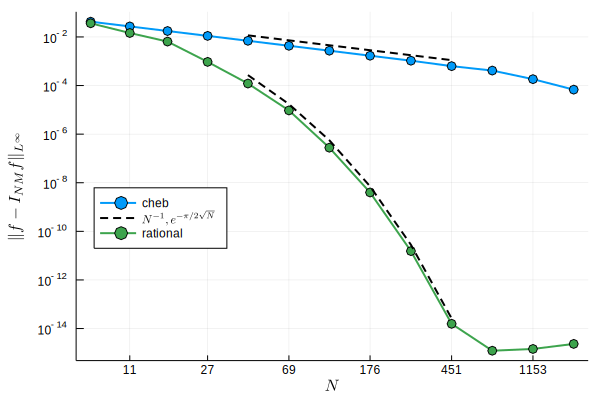

In [33]:
NN = ceil.(Int, (1.6).^(4:16))
xerr = errgrid(2_000)
P = plot(xaxis = (:log, L"N",), 
         yaxis = (:log, L"\| f - I_{NM} f\|_{L^\infty}"), 
         legend=:left)
err_poly = [ norm(abs.(xerr) - bary(abs, 2*N, xerr), Inf) for N in NN ]
err_rat = [ norm(abs.(xerr) - rabs.(xerr, N), Inf) for N in NN ]
t = NN[5:end-3]
plot!(NN, err_poly, lw=2, m=:o, label = "cheb")
plot!(t, 0.5*t.^(-1), c=:black, ls=:dash, lw=2, label=L"N^{-1}, e^{-\pi/2 \sqrt{N}}")
plot!(NN, err_rat, lw=2, m=:o, label = "rational")
plot!(t, 8*exp.(-π/2*t.^(1/2)), c=:black, lw=2, ls=:dash, label = "")
xticks!(NN[2:2:end], string.(NN[2:2:end]))

### 07-03 Best Approximation / Remez

To conclude this section perform a few final tests with the Remez algorithm to see who best approximation compares against our previously constructed examples. A Remez algorithm implementation in `Julia` is given by the package `Remez.jl`.

In [ ]:
?ratfn_minimax

In [ ]:
# a basic "special function" that we tried to implement
# the result here is rather disappointing...
# --------------------------------------------------------
f(x) = sin( (1+x)*π/4 )
tsin(N, x) = imag(sum((im*x)^n / factorial(n) for n = 0:N))
ft(N, x) = tsin(N, (1+x)*π/4)
xerr = errgrid(1_000)
NN = 2:2:10
NNr = [ (2,0), (4,0), (4,2), (6,2), (8,2) ]
err_taylor = [ norm(f.(xerr) - ft.(N, xerr), Inf) for N = NN ]
err_cheb = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N = NN ]
err_remez = [ ratfn_minimax(f, (-1, 1), N, 0)[3] for N in NN ]
err_rat = [ ratfn_minimax(f, (-1, 1), Nn, Nd)[3] for (Nn, Nd) in NNr ]
plot(xaxis = (L"N",), 
     yaxis = (:log, L"\| f - p_N \|_{L^\infty}"))
plot!(NN, err_taylor, lw=2, m=:o, label = "taylor")
plot!(NN, err_cheb, lw=2, m=:o, label = "cheb")
plot!(NN, err_remez, lw=2, m=:o, label = "remez")
plot!(NN, err_rat, lw=2, m=:o, label = "remez-rat")

In [ ]:
N = 8
xp = errgrid(400)
plot(xp, abs.(f.(xp) - ft.(N, xp)), lw=2, label="taylor",
     yaxis=([-1e-10, 2e-9],))
plot!(xp, abs.(f.(xp) - bary(f, N, xp)), lw=2, label="cheb")
Pbest = ratfn_minimax(f, (-1, 1), N, 0)
pbest = [ Remez.ratfn_eval(Pbest[1], Pbest[2], BigFloat(x)) for x in xp ]
plot!(xp, abs.(f.(xp) - pbest), lw=2, label="remez")

In [ ]:
# Chebyshev vs Remez for the Fermi-Dirac Example 
# -----------------------------------------------
β = 100
f(x) = 1/(1+exp(β*x))
NN = 10:10:100
Nr = 5:5:60
xerr = errgrid(1_000)
err = [ norm(f.(xerr) - bary(f, N, xerr), Inf)  for N in NN ]
errremez = [ ratfn_minimax(f, (-1, 1), N, 0)[3] for N in Nr ]
# errremrat = [ ratfn_minimax(f, (-1, 1), N÷2, N÷2)[3] for N = 2:2:10 ]
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_{NM} f\|_{L^\infty}"))
plot!(NN, err, lw=2, m=:o, label = "cheb")
# plot!(Nr, errsuper, lw=2, m=:o, label = "rational")
plot!(Nr, errremez, lw=2, m=:o, label = "Remez")
# plot!(Nr, errremrat, lw=2, m=:o, label = "Remez-Rat")

This may still seem modest, but can be significant in some situations. E.g., if we are trying to evaluate $f(H)$ where $H$ is a large matrix, then reducing the number of matrix multiplications from 100 to 60 is almost a halving of computational cost. When that cost is no longer in the ms but more in the "hours" or "days" range, then this begins to matter. 
 
A similar conclusion applies to the next Example

In [ ]:
# Chebyshev vs Remez for the abs(x) Example 
# ------------------------------------------
NN = 4:4:40
xerr = errgrid(1_000)
err_poly = [ norm(abs.(xerr) - bary(abs, 2*N, xerr)) for N in NN ]
err_rat = [ norm(abs.(xerr) - rabs.(xerr, N)) for N in NN ]
err_remez = [ ratfn_minimax(abs, (-1, 1), N, 0)[3] for N in NN ]
# err_remrat = [ ratfn_minimax(abs, (-1, 1), N, N)[3] for N in NN ]   # UNSTABLE?
P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_{NM} f\|_{L^\infty}"))
plot!(NN, err_poly, lw=2, m=:o, label = "cheb")
plot!(NN, err_rat, lw=2, m=:o, label = "rational")
plot!(NN, err_remez, lw=2, m=:o, label = "best-poly")
# plot!(NN, err_remrat, lw=2, m=:o, label = "best-rat")

This is a more significant example; note that the point $N = 40$ for Chebyshev interpolation has a similar error as the point $N = 8$ for best-approximation! And even our rational approximation does not come close in the pre-asymptotic regime!

In [ ]:
using SpecialFunctions

In [ ]:
# erf on the interval t ∈ [0, 6]
# x ∈ [-1,1] => t = 3*(x+1)
# 1 - erf(x) ~ exp(-x^2) so rescale as follows:
ferf(x) = exp((3*(1+x))^2) * (1 - erfc((3*(1+x))))

NN = 4:4:40
Nr = 2:6
xerr = errgrid(1_000)
err_poly = [ norm(ferf.(xerr) - bary(ferf, N, xerr)) for N in NN ]
err_remez = [ ratfn_minimax(ferf, (-1, 1), N, 0)[3] for N in NN ]
# err_remrat = [ ratfn_minimax(ferf, (-1, 1), N, N)[3] for N in Nr ]  

P = plot(xaxis = (L"N",), 
         yaxis = (:log, L"\| f - I_{NM} f\|_{L^\infty}"))
plot!(NN, err_poly, lw=2, m=:o, label = "cheb")
plot!(NN, err_remez, lw=2, m=:o, label = "best-poly")
# plot!(Nr, err_remrat, lw=2, m=:o, label = "best-rational")N